## Figures

In [1]:
import sys
import warnings

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb
from tqdm import tqdm
from itertools import combinations
from tqdm import tqdm

sys.path.append("../src/")

import xgi
from reducibility_hg import *

from statannotations.Annotator import Annotator

sb.set_theme(style="ticks", context="paper")

In [2]:
results_dir = "../results/"
out_dir = f"{results_dir}datasets/"

In [3]:
# def sigma(d):
#    """
#    Return d*(d+1)/2, the sum of the first d integers"""
#    return d * (d + 1) / 2

## try dataset

In [4]:
xgi.load_xgi_data()

Available datasets are the following:
coauth-dblp
coauth-mag-geology
coauth-mag-history
congress-bills
contact-high-school
contact-primary-school
dawn
diseasome
disgenenet
email-enron
email-eu
hospital-lyon
hypertext-conference
invs13
invs15
kaggle-whats-cooking
malawi-village
ndc-classes
ndc-substances
science-gallery
sfhh-conference
tags-ask-ubuntu
tags-math-sx
tags-stack-overflow


In [26]:
data_names = [
    #"email-enron",
    #"email-eu",
    #"kaggle-whats-cooking",
    #"hospital-lyon",
    #"contact-high-school",
    #"contact-primary-school",
    #"sfhh-conference",
    #"hypertext-conference",
    #"science-gallery",
    #"invs13",
    #"invs15",
    #"tags-ask-ubuntu",
    #"tags-math-sx",
    #"tags-stack-overflow",
    #"congress-bills",
    #"disgenenet",
    #"diseasome",
    #"malawi-village",
    #"ndc-classes",
    #"ndc-substances",
    "coauth-mag-geology",
    # "coauth-mag-history",
    # "coauth-dblp",
    #"dawn"
]

HGs = {}
for name in tqdm(data_names):
    HGs[name] = xgi.load_xgi_data(name, max_order=None, cache=True)

100%|█████████████████████████████████████████████| 1/1 [00:33<00:00, 33.47s/it]


In [30]:
i = 0  # choose dataset here
name = data_names[i]
print(name)
H0 = HGs[name]
print(H0)
print("max order:", xgi.max_edge_order(H0))
H0.cleanup(isolates=True)
print(H0)

orders = np.array(xgi.unique_edge_sizes(H0)) - 1
weights = np.ones(len(orders))
N = H0.num_nodes

rescale = True

H = H0.copy()

coauth-mag-geology
Hypergraph named coauth-MAG-Geology with 898648 nodes and 833158 hyperedges
max order: 24
Hypergraph named coauth-MAG-Geology with 898648 nodes and 833158 hyperedges


In [102]:
# slice by years for coauthorship

years = [H.edges[i]["timestamp"] for i in H.edges]
year = 1983
name = data_names[i]
name += f"_{year}"
idx_keep = np.where(np.array(years)==year)[0]
#idx_keep
H0 = xgi.subhypergraph(H, edges=idx_keep).copy()

print(H0)
H0.cleanup(isolates=False, singletons=True, connected=True)
print(H0)

# H0 = H
orders = np.array(xgi.unique_edge_sizes(H0)) - 1
weights = np.ones(len(orders))
N = H0.num_nodes

Hypergraph named coauth-MAG-Geology with 898648 nodes and 6396 hyperedges
Hypergraph named coauth-MAG-Geology with 535 nodes and 245 hyperedges


In [103]:
name

'coauth-mag-geology_1983'

In [104]:
sparse = False

In [105]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=UserWarning)
    
    tau_c = find_charact_tau(H0, orders, weights, rescale_per_node=rescale, sparse_Lap=True, idx=-1)
tau_c

0.013366173275514598

In [106]:
inverse_rescaling_factors = [max(orders) / d for d in orders]

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=UserWarning)

    Ds_H, lZs_H = optimization(
        H0,
        tau_c,
        rescaling_factors=inverse_rescaling_factors,
        rescale_per_node=rescale,
        sparse=sparse,
        sparse_Lap=True,
    )

100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.33it/s]


In [107]:
#xgi.load_xgi_data()

In [108]:
#name = "hypertext-conference"
#data = np.load(f"{out_dir}/message_length_{name}.npz")

#message_length = data["message_length"]
#Ds_H = data["KL"]
#lZs_H = data["complexity"]
#orders = data["orders"]
#N = int(data["N"])

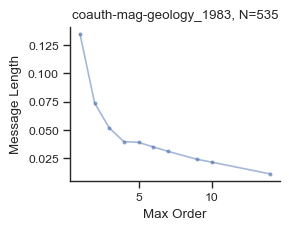

In [109]:
fig, ax = plt.subplots(1, 1, figsize=(2.7, 2))

message_length = Ds_H + lZs_H
ax.plot(orders, message_length, "o-", ms=2, alpha=0.5)


ax.set_ylabel("Message Length")
ax.set_xlabel("Max Order")
ax.set_title("functional complex.")

# ax.set_title(f"{name} {year}, N={N}")
ax.set_title(f"{name}, N={N}")

sb.despine()

# fig_name = f"message_length_{name}_{year}_rescaled_tauc"
fig_name = f"message_length_{name}_rescaled_tauc"

plt.savefig(f"{out_dir}{fig_name}.png", dpi=250, bbox_inches="tight")

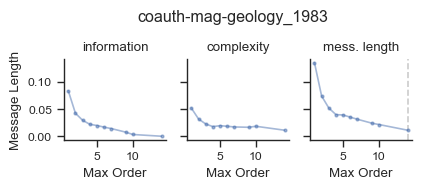

In [110]:
fig, axs = plt.subplots(1, 3, figsize=(4.5, 1.5), sharey=True)

message_length = Ds_H + lZs_H

axs[0].plot(orders, Ds_H, "o-", ms=2, alpha=0.5)
axs[0].set_title("information")

axs[1].plot(orders, lZs_H, "o-", ms=2, alpha=0.5)
axs[1].set_title("complexity")

axs[2].plot(orders, message_length, "o-", ms=2, alpha=0.5)
axs[2].set_title("mess. length")


axs[0].set_ylabel("Message Length")
axs[0].set_xlabel("Max Order")
axs[1].set_xlabel("Max Order")
axs[2].set_xlabel("Max Order")

order_argmin = np.argmin(message_length)
order_min = orders[order_argmin]

axs[2].axvline(order_min, ls="--", c="grey", zorder=-2, alpha=0.4)

# ax.set_title("functional complex.")

# ax.set_title(f"{name} {year}, N={N}")
# fig.suptitle(f"{name}_{year}")
fig.suptitle(f"{name}")

sb.despine()
plt.subplots_adjust(top=0.65)

# fig_name = f"message_length_{name}_{year}_rescaled_tauc_full"
fig_name = f"message_length_{name}_rescaled_tauc_full"

plt.savefig(f"{out_dir}{fig_name}.png", dpi=250, bbox_inches="tight")

In [111]:
np.savez(
    f"{out_dir}/message_length_{name}.npz",
    # f"{out_dir}/message_length_{name}_{year}.npz",
    message_length=Ds_H + lZs_H,
    KL=Ds_H,
    complexity=lZs_H,
    orders=orders,
    dataset=name,
    # year=year,
    N=N,
    num_edges=H0.num_edges,
    tau_c=tau_c,
    order_min=order_min
)

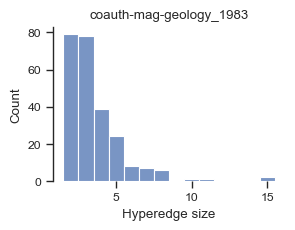

In [112]:
bins = np.arange(1.5, max(orders)+1 + 1.5, 1) 

fig, ax = plt.subplots(figsize=(3, 2))

sb.histplot(H0.edges.size.asnumpy(), bins=bins)

ax.set_xlabel("Hyperedge size")
ax.set_title(name)

sb.despine(bottom=True)

fig_name = f"dataset_{name}_edge_size_hist"

plt.savefig(f"{out_dir}{fig_name}.png", dpi=250, bbox_inches="tight")

In [113]:
name

'coauth-mag-geology_1983'

In [17]:
xgi.unique_edge_sizes(H0)

[2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185,
 1

In [18]:
np.unique(H0.edges.size.asnumpy(), return_counts=True)

(array([  2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,
         15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,
         41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,
         54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
         67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,
         80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
         93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
        106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
        119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131,
        132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144,
        145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157,
        158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170,
        171, 172, 173, 174, 175, 176, 177, 178, 179

## all together

In [18]:
data_names = [
    "email-enron",
    # "email-eu",
    "hospital-lyon",
    "contact-high-school",
    # "contact-primary-school",
    # "tags-ask-ubuntu",
    # "congress-bills",
    # "disgenenet",
    # "diseasome",
    # "ndc-substances",
    # "coauth-mag-geology",
    # "coauth-mag-history",
]

HGs = {}
for name in tqdm(data_names):
    HGs[name] = xgi.load_xgi_data(name, max_order=None, cache=True)

100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.21it/s]


In [19]:
rescale = True

message_length_arr = []
orders_arr = []

for i, H0 in enumerate(tqdm(HGs)):

    # load and clean
    name = data_names[i]
    H0 = HGs[name]
    print(H0)
    print("max order:", xgi.max_edge_order(H0))
    H0.cleanup(isolates=True)
    print(H0)

    orders = np.array(xgi.unique_edge_sizes(H0)) - 1
    weights = np.ones(len(orders))
    N = H0.num_nodes

    # compute
    tau_c = find_charact_tau(H0, orders, weights, rescale_per_node=rescale, idx=-1)

    inverse_rescaling_factors = [max(orders) / d for d in orders]
    Ds_H, lZs_H = optimization(
        H0, tau_c, rescaling_factors=inverse_rescaling_factors, rescale_per_node=rescale
    )

    message_length = Ds_H + lZs_H

    message_length_arr.append(message_length)
    orders_arr.append(orders)

  0%|                                                     | 0/3 [00:00<?, ?it/s]

Hypergraph named email-Enron with 148 nodes and 10885 hyperedges
max order: 36
Hypergraph named email-Enron with 143 nodes and 1459 hyperedges


 33%|███████████████                              | 1/3 [00:18<00:36, 18.28s/it]

Hypergraph named hospital-lyon with 75 nodes and 27834 hyperedges
max order: 4
Hypergraph named hospital-lyon with 75 nodes and 1824 hyperedges


 67%|██████████████████████████████               | 2/3 [00:19<00:08,  8.45s/it]

Hypergraph named contact-high-school with 327 nodes and 172035 hyperedges
max order: 4
Hypergraph named contact-high-school with 327 nodes and 7818 hyperedges
logm result may be inaccurate, approximate err = 5.128841825295042e-13
logm result may be inaccurate, approximate err = 4.641378397856407e-13
logm result may be inaccurate, approximate err = 5.128841825295042e-13
logm result may be inaccurate, approximate err = 4.887420895249281e-13
logm result may be inaccurate, approximate err = 5.128841825295042e-13
logm result may be inaccurate, approximate err = 4.570432369407865e-13
logm result may be inaccurate, approximate err = 5.128841825295042e-13


100%|█████████████████████████████████████████████| 3/3 [00:29<00:00,  9.88s/it]

logm result may be inaccurate, approximate err = 5.128841825295042e-13


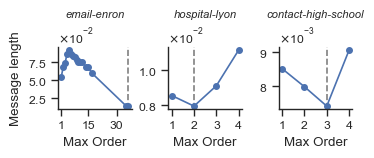

In [20]:
fig, axs = plt.subplots(
    1, len(data_names), figsize=(3.8, 0.8), sharey=False
)  # , layout="constrained")

for i, name in enumerate(data_names):

    ax = axs[i]
    ax.plot(orders_arr[i], message_length_arr[i], "o-", ms=4)

    order_argmin = np.argmin(message_length_arr[i])
    order_min = orders_arr[i][order_argmin]

    ax.axvline(order_min, ls="--", c="grey", zorder=-2)
    ax.set_xlabel("Max Order")
    ax.ticklabel_format(
        axis="y", style="scientific", scilimits=(0, 0), useMathText=True, useOffset=True
    )

    ax.set_title(name, fontsize="small", style="italic")

axs[0].set_ylabel("Message length")
axs[0].set_xticks([1, 15, 30])
axs[1].set_xticks([1, 2, 3, 4])
axs[2].set_xticks([1, 2, 3, 4])

plt.subplots_adjust(wspace=0.5)

sb.despine()

fig_name = f"figure_3"
plt.savefig(f"{out_dir}{fig_name}.png", dpi=250, bbox_inches="tight")
plt.savefig(f"{out_dir}{fig_name}.pdf", dpi=250, bbox_inches="tight")